# Classification of dangerous asteroids

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Toolbox files of interest
import sys
sys.path.append('./../../src/classification')
sys.path.append('./../../utils')

# Import methods and classes
from classifier import GeneralClassifier, test_all_models
from classifier_logistic import LogisticClassifier
from classifier_decision_tree import DecTreeClassifier
from classifier_random_forest import RandForestClassifier
from classifier_gradient_boosting import GradBoostingClassifier
from classifier_nn import NeuralNetClassifier
from scaling import find_scaler, normalize, rescale
from classification_tools import compute_classification_metrics

## Data preparation

In [3]:
# Loading (must be a pandas dataframe with valide data type)
data = pd.read_csv('../../data/pair-1e4.csv')
X = data[['Diameter', 'Density', 'Strength', 'Velocity', 'Angle', 'Azimuth', 'Alpha', 'LumEff', 'Ablation']]
y = data[['BlastRad1']]

# Data classes preparation
y_classified = y.copy()
y_classified.loc[y['BlastRad1'] <= 1e-3, 'BlastRad1'] = 0.0
y_classified.loc[y['BlastRad1'] > 1e-3, 'BlastRad1'] = 1.0

In [4]:
# Normalizing
X_scaler = find_scaler(X)
X_normalized = normalize(X, X_scaler)
y_classified['BlastRad1'] = y_classified['BlastRad1'].astype(int)

# Spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_classified, test_size=0.2, random_state=42)
y_train_no_class, y_test_no_class = train_test_split(y, test_size=0.2, random_state=42)

## Models exploration

In [19]:
# Optimize hyperparameters, train and test all models with xval
df_comparison = test_all_models(X_normalized, y_classified)

Logistic

Decision Tree
The best hyperparameters are:
max_depth = 8          options = [3, 4, 8, 12]

Random forest
The best hyperparameters are:
max_depth = 12          options = [3, 4, 8, 12]

Gradient boosting
The best hyperparameters are:
learning_rate = 0.5          options = [0.05, 0.1, 0.5]
subsample = 0.8          options = [0.2, 0.8]
max_depth = 4          options = [4, 8]

Neural network
The best hyperparameters are:
regularizer = 0          options = [0, 0.01, 0.1, 1]
learning_rate = 0.01          options = [0.001, 0.01, 0.1]


In [20]:
df_comparison.head(n=10)

,Model,Accuracy,Precision,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate
0,Logisitic,91.4,100.0,82.0,0.0,100.0,18.0
1,Decision Tree,97.2,96.4,97.6,3.2,96.8,2.4
2,Random Forest,98.2,98.5,97.7,1.3,98.7,2.3
3,Gradient Boosting,98.9,99.0,98.7,1.0,99.0,1.3
4,Neural Net,98.7,98.8,98.4,1.1,98.9,1.6


In [5]:
# Logistic classification
cla_log = LogisticClassifier()
model_log, y_pred_log = cla_log.train_and_infer(X_train, y_train, X_test)
cla_metrics_log = compute_classification_metrics(y_test, y_pred_log)
y_pred_log_all = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_log), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

# Decision tree classifier
cla_dt = DecTreeClassifier(max_depth=3)
model_dt, y_pred_dt = cla_dt.train_and_infer(X_train, y_train, X_test)
cla_metrics_dt = compute_classification_metrics(y_test, y_pred_dt)
y_pred_dt_all = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_dt), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

# Random forest classifier
cla_rf = RandForestClassifier(max_depth=12)
model_rf, y_pred_rf = cla_rf.train_and_infer(X_train, y_train, X_test)
cla_metrics_rf = compute_classification_metrics(y_test, y_pred_rf)
y_pred_rf_all = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_rf), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

# Gradient boosting classifier
cla_gb = GradBoostingClassifier(learning_rate=0.5, subsample=0.8, max_depth=4)
model_gb, y_pred_gb = cla_gb.train_and_infer(X_train, y_train, X_test)
cla_metrics_gb = compute_classification_metrics(y_test, y_pred_gb)
y_pred_gb_all = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_gb), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

# Neural network classifier
cla_nn = NeuralNetClassifier(regularizer=0.0, learning_rate=0.01)
model_nn, y_pred_nn = cla_nn.train_and_infer(X_train, y_train, X_test)
cla_metrics_nn = compute_classification_metrics(y_test, y_pred_nn)
y_pred_nn_all = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_nn), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

2023-01-10 16:02:33.228752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


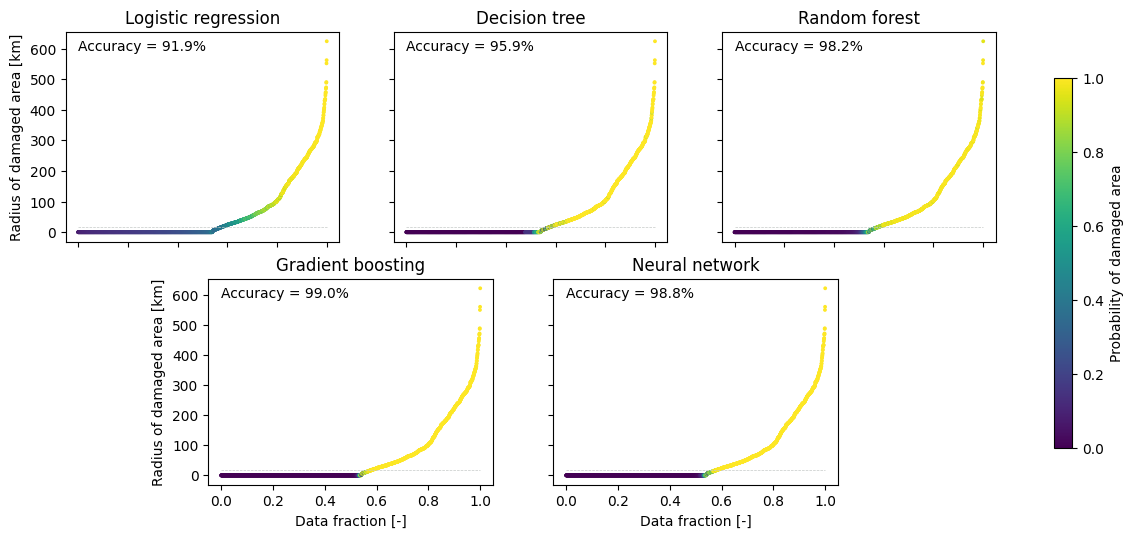

In [6]:
# Figure parameters
top = 0.001 * y_test_no_class.max()
class_lim = 18.5

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
pcm = axs[0,0].set_title('Logistic regression')
pcm = axs[0,0].annotate('Accuracy = ' + str(cla_metrics_log[0]) + '%', xy=(0, 0.95 * top))
pcm = axs[0,0].scatter(np.linspace(0,1,y_pred_log_all.shape[0]), 0.001 * y_pred_log_all['y_test'], s=3, c=y_pred_log_all['y_pred'].to_numpy(),cmap='viridis', vmin=0, vmax=1)
pcm = axs[0,1].set_title('Decision tree')
pcm = axs[0,1].annotate('Accuracy = ' + str(cla_metrics_dt[0]) + '%', xy=(0, 0.95 * top))
pcm = axs[0,1].scatter(np.linspace(0,1,y_pred_dt_all.shape[0]), 0.001 * y_pred_dt_all['y_test'], s=3, c=y_pred_dt_all['y_pred'].to_numpy(),cmap='viridis', vmin=0, vmax=1)
pcm = axs[0,2].set_title('Random forest')
pcm = axs[0,2].annotate('Accuracy = ' + str(cla_metrics_rf[0]) + '%', xy=(0, 0.95 * top))
pcm = axs[0,2].scatter(np.linspace(0,1,y_pred_rf_all.shape[0]), 0.001 * y_pred_rf_all['y_test'], s=3, c=y_pred_rf_all['y_pred'].to_numpy(),cmap='viridis', vmin=0, vmax=1)
pcm = axs[1,0].set_title('Gradient boosting')
pcm = axs[1,0].annotate('Accuracy = ' + str(cla_metrics_gb[0]) + '%', xy=(0, 0.95 * top))
pcm = axs[1,0].scatter(np.linspace(0,1,y_pred_gb_all.shape[0]), 0.001 * y_pred_gb_all['y_test'], s=3, c=y_pred_gb_all['y_pred'].to_numpy(),cmap='viridis', vmin=0, vmax=1)
pcm = axs[1,1].set_title('Neural network')
pcm = axs[1,1].annotate('Accuracy = ' + str(cla_metrics_nn[0]) + '%', xy=(0, 0.95 * top))
pcm = axs[1,1].scatter(np.linspace(0,1,y_pred_nn_all.shape[0]), 0.001 * y_pred_nn_all['y_test'], s=3, c=y_pred_nn_all['y_pred'].to_numpy(),cmap='viridis', vmin=0, vmax=1)
fig.colorbar(pcm, ax=axs[:, :], shrink=0.8, label='Probability of damaged area')

for ax in axs.flat:
    ax.label_outer()
    ax.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=0.5, c='#C5C9C7')

# Manage the shift
axs[1][2].set_visible(False)
axs[1][0].set_position([0.22,0.125,0.19,0.343])
axs[1][1].set_position([0.45,0.125,0.19,0.343])
    
plt.setp(axs[-1, :], xlabel='Data fraction [-]')
plt.setp(axs[:, 0], ylabel='Radius of damaged area [km]')
plt.show()

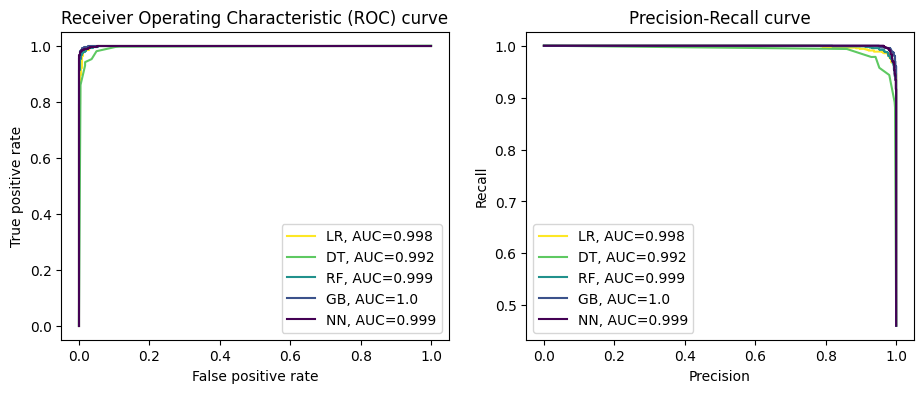

In [10]:
# ROC AUC
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

# Calculating the ROC AUC
roc_auc_log = roc_auc_score(y_test, y_pred_log)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
roc_auc_nn = roc_auc_score(y_test, y_pred_nn)

# False positive and true negative rates
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)

# Precision and recall
precision_log, recall_log, _ = precision_recall_curve(y_test, y_pred_log)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_dt)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_gb)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_nn)

# Calculating the precision-recall AUC
pr_auc_log = auc(recall_log, precision_log)
pr_auc_dt = auc(recall_dt, precision_dt)
pr_auc_rf = auc(recall_rf, precision_rf)
pr_auc_gb = auc(recall_gb, precision_gb)
pr_auc_nn = auc(recall_nn, precision_nn)

# Plot the figure
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
cmap=plt.cm.viridis
axs[0].plot(fpr_log, tpr_log, c=cmap(1.0), label='LR, AUC='+ str(round(roc_auc_log, 2)))
axs[0].plot(fpr_dt, tpr_dt, c=cmap(0.75),  label='DT, AUC=' + str(round(roc_auc_dt,2)))
axs[0].plot(fpr_rf, tpr_rf, c=cmap(0.5),   label='RF, AUC=' + str(round(roc_auc_rf,2)))
axs[0].plot(fpr_gb, tpr_gb, c=cmap(0.25),  label='GB, AUC=' + str(round(roc_auc_gb,2)))
axs[0].plot(fpr_nn, tpr_nn, c=cmap(0.0),   label='NN, AUC=' + str(round(roc_auc_nn,2)))
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) curve')
axs[0].legend()

axs[1].plot(recall_log, precision_log, c=cmap(1.0), label='LR, AUC='+ str(round(pr_auc_log, 2)))
axs[1].plot(recall_dt, precision_dt, c=cmap(0.75),  label='DT, AUC=' + str(round(pr_auc_dt,2)))
axs[1].plot(recall_rf, precision_rf, c=cmap(0.5),   label='RF, AUC=' + str(round(pr_auc_rf,2)))
axs[1].plot(recall_gb, precision_gb, c=cmap(0.25),  label='GB, AUC=' + str(round(pr_auc_gb,2)))
axs[1].plot(recall_nn, precision_nn, c=cmap(0.0),   label='NN, AUC=' + str(round(pr_auc_nn,2)))
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].set_title('Precision-Recall curve')
axs[1].legend()
plt.show()

## Model exploitation

In [21]:
cla_nn_adv = NeuralNetClassifier()
df_grid_search_nn = cla_nn_adv.optimize_hyperparameters(X_normalized, y_classified, regularizers=[0, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1], 
                                                                                learning_rates=[0.001, 0.0025, 0.005, 0.0075, 0.01, 0.05, 0.1])
model_nn_adv, y_pred_nn_adv = cla_nn_adv.train_and_infer(X_train, y_train, X_test)
cla_metrics_nn_adv = compute_classification_metrics(y_test, y_pred_nn_adv)
y_pred_nn_all_adv = pd.DataFrame(data=np.concatenate((y_test_no_class, y_pred_nn_adv), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])

The best hyperparameters are:
regularizer = 0          options = [0, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1]
learning_rate = 0.005          options = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.05, 0.1]


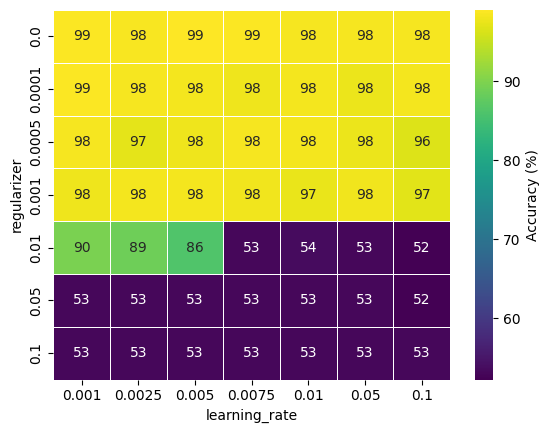

In [22]:
df_grid_search_nn.head(n=15)
df_grid_search_nn = df_grid_search_nn.pivot("regularizer", "learning_rate", "acc")
ax = sns.heatmap(df_grid_search_nn,
                cmap='viridis', 
                annot=True, 
                linewidths=.5,
                cbar_kws={'label': 'Accuracy (%)'})

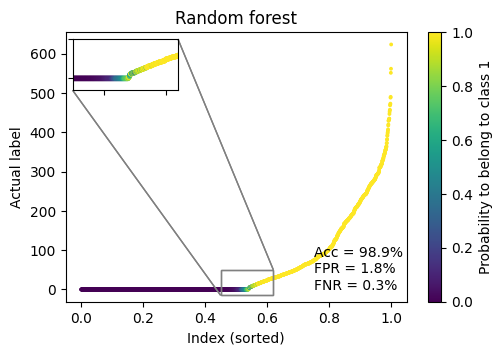

In [27]:
# Plot the results of one model in particular

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=[5.5,3.5])
sp = ax.scatter(np.linspace(0,1,y_pred_nn_all_adv.shape[0]), 0.001 * y_pred_nn_all_adv['y_test'], s=3, c=y_pred_nn_all_adv['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# ax.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=0.5, c='#C5C9C7')
ax.annotate('Acc = ' + str(cla_metrics_nn_adv[0]) + '%\nFPR = ' + str(cla_metrics_nn_adv[3]) + '%\nFNR = ' + str(cla_metrics_nn_adv[5]) + '%', xy=(0.75, y_test_no_class.min(axis=0)))
ax.set_title('Random forest')
ax.set_xlabel('Index (sorted)')
ax.set_ylabel('Actual label')

axins = zoomed_inset_axes(ax, 2, loc='upper left') 
axins.scatter(np.linspace(0,1,y_pred_nn_all_adv.shape[0]), 0.001 * y_pred_nn_all_adv['y_test'], s=8, c=y_pred_nn_all_adv['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# axins.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=1.5, c='#C5C9C7')
axins.set_xlim(0.45, 0.62)
axins.set_ylim(-15, 50)

plt.xticks(visible=False)  
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
mark_inset(ax, axins, loc1=3, loc2=3, fc="none", ec="0.5")

plt.draw()
fig.colorbar(sp, ax=ax, label='Probability to belong to class 1')
plt.show()

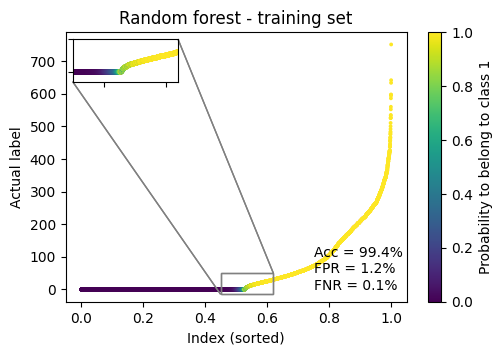

In [29]:
# Infer on any other set (training set for instance to analyze overfiting)
y_pred_nn_train = cla_nn_adv.infer(X_train, model_nn_adv)
cla_metrics_nn_train = compute_classification_metrics(y_train, y_pred_nn_train)
y_pred_nn_train_all = pd.DataFrame(data=np.concatenate((y_train_no_class, y_pred_nn_train), axis=1),
                                columns=['y_test', 'y_pred']).sort_values(by=['y_test', 'y_pred'])


# Plot the results of one model in particular
fig, ax = plt.subplots(figsize=[5.5,3.5])
sp = ax.scatter(np.linspace(0,1,y_pred_nn_train_all.shape[0]), 0.001 * y_pred_nn_train_all['y_test'], s=3, c=y_pred_nn_train_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# ax.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=0.5, c='#C5C9C7')
ax.annotate('Acc = ' + str(cla_metrics_nn_train[0]) + '%\nFPR = ' + str(cla_metrics_nn_train[3]) + '%\nFNR = ' + str(cla_metrics_nn_train[5]) + '%', xy=(0.75, y_train_no_class.min(axis=0)))
ax.set_title('Random forest - training set')
ax.set_xlabel('Index (sorted)')
ax.set_ylabel('Actual label')

axins = zoomed_inset_axes(ax, 2, loc='upper left') 
axins.scatter(np.linspace(0,1,y_pred_nn_train_all.shape[0]), 0.001 * y_pred_nn_train_all['y_test'], s=8, c=y_pred_nn_train_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# axins.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=1.5, c='#C5C9C7')
axins.set_xlim(0.45, 0.62)
axins.set_ylim(-15, 50)

plt.xticks(visible=False)  
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
mark_inset(ax, axins, loc1=3, loc2=3, fc="none", ec="0.5")

plt.draw()
fig.colorbar(sp, ax=ax, label='Probability to belong to class 1')
plt.show()

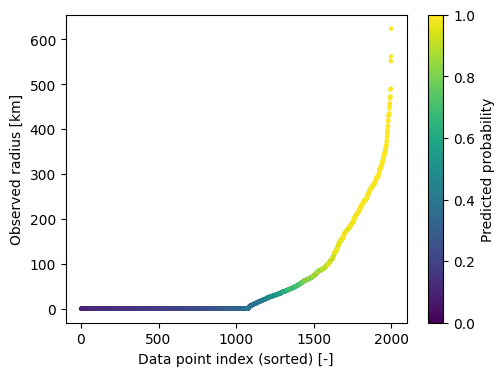

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


# Plot the results of one model in particular
fig, ax = plt.subplots(figsize=[5.5,4.0])
sp = ax.scatter(np.linspace(1,y_pred_log_all.shape[0],y_pred_log_all.shape[0]), 0.001 * y_pred_log_all['y_test'], s=5, c=y_pred_log_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# ax.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=0.5, c='#C5C9C7')
# ax.annotate('Acc = ' + str(cla_metrics_nn_train[0]) + '%\nFPR = ' + str(cla_metrics_nn_train[3]) + '%\nFNR = ' + str(cla_metrics_nn_train[5]) + '%', xy=(0.75, y_train_no_class.min(axis=0)))
# ax.set_title('Logistic regression')
ax.set_xlabel('Data point index (sorted) [-]')
ax.set_ylabel('Observed radius [km]')

# axins = zoomed_inset_axes(ax, 2, loc='upper left') 
# axins.scatter(np.linspace(0,1,y_pred_log_all.shape[0]), 0.001 * y_pred_log_all['y_test'], s=8, c=y_pred_log_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# # axins.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=1.5, c='#C5C9C7')
# axins.set_xlim(0.45, 0.62)
# axins.set_ylim(-15, 50)

# plt.xticks(visible=False)  
# plt.yticks(visible=False)
# mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
# mark_inset(ax, axins, loc1=3, loc2=3, fc="none", ec="0.5")


plt.draw()
fig.colorbar(sp, ax=ax, label='Predicted probability')
plt.show()

fig.savefig("cla_log.pdf", bbox_inches="tight") 

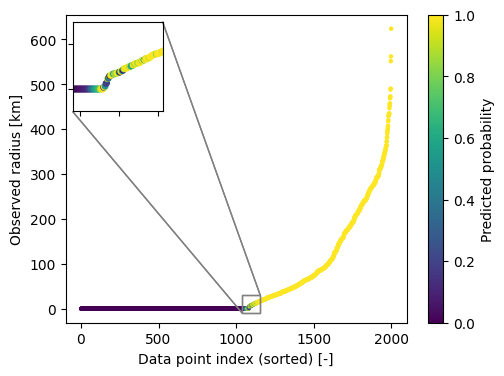

In [35]:
# Plot the results of one model in particular
fig, ax = plt.subplots(figsize=[5.5,4.0])
sp = ax.scatter(np.linspace(1,y_pred_gb_all.shape[0],y_pred_gb_all.shape[0]), 0.001 * y_pred_gb_all['y_test'], s=5, c=y_pred_gb_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# ax.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=0.5, c='#C5C9C7')
# ax.annotate('Acc = ' + str(cla_metrics_nn_train[0]) + '%\nFPR = ' + str(cla_metrics_nn_train[3]) + '%\nFNR = ' + str(cla_metrics_nn_train[5]) + '%', xy=(0.75, y_train_no_class.min(axis=0)))
# ax.set_title('Gradient boosting classifier')
ax.set_xlabel('Data point index (sorted) [-]')
ax.set_ylabel('Observed radius [km]')

axins = zoomed_inset_axes(ax, 5, loc='upper left') 
axins.scatter(np.linspace(1,y_pred_gb_all.shape[0],y_pred_gb_all.shape[0]), 0.001 * y_pred_gb_all['y_test'], s=15, c=y_pred_gb_all['y_pred'].to_numpy(), cmap=plt.cm.viridis, vmin=0, vmax=1)
# axins.plot([0, 1], [class_lim, class_lim], linestyle='--', linewidth=1.5, c='#C5C9C7')
axins.set_xlim(1040, 1156)
axins.set_ylim(-10, 30)

plt.xticks(visible=False)  
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=1, fc="none", ec="0.5")
mark_inset(ax, axins, loc1=3, loc2=3, fc="none", ec="0.5")

plt.draw()
fig.colorbar(sp, ax=ax, label='Predicted probability')
plt.show()

fig.savefig("cla_gb.pdf", bbox_inches="tight") 

## Save and load

In [14]:
# Save model
import os
output_folder = './models/classification/'
os.makedirs(output_folder, exist_ok=True)

cla_log.save_model(model_log, './models/classification/logistic_test')
cla_dt.save_model(model_dt, './models/classification/dec_tree_test')
cla_rf.save_model(model_rf, './models/classification/rand_forest_test')
cla_gb.save_model(model_gb, './models/classification/grad_boost_test')
cla_nn.save_model(model_nn, './models/classification/neural_net_test')

# Load model
cla_log = LogisticClassifier()
model_log_loaded = cla_log.save_model(model_log, './models/classification/logistic_test')
cla_dt = DecTreeClassifier()
model_dt_loaded = cla_dt.save_model(model_dt, './models/classification/dec_tree_test')
cla_rf = RandForestClassifier()
model_rf_loaded = cla_rf.save_model(model_rf, './models/classification/rand_forest_test')
cla_gb = GradBoostingClassifier()
model_gb_loaded = cla_gb.save_model(model_gb, './models/classification/grad_boost_test')
cla_nn = NeuralNetClassifier()
model_nn_loaded = cla_nn.save_model(model_nn, './models/classification/neural_net_test')

INFO:tensorflow:Assets written to: ./models/classification/neural_net_test/assets
INFO:tensorflow:Assets written to: ./models/classification/neural_net_test/assets
